In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from joblib import dump, load


from sklearn.feature_selection import mutual_info_classif


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

    to det a dataset from iris

In [21]:
# from sklearn.datasets load_iris()
# x=pd.DataFrame(iris.data, columns=iris.feature_names)
# y=pd.DataFrame(iris.target, columns=['target'])
# y=pd.Series(iris.target, name='target')
# df = pd.concat([x, y], axis=1)
# df = pd.read_csv('data/iris.csv')


In [22]:
df = pd.read_csv('train-4.csv')  
df.head()

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0

In [23]:
df.drop(['id'], axis=1, inplace=True)
df.drop(['day'], axis=1, inplace=True)

# Pipeline for Column Transformation

In [24]:
num_cols = df.select_dtypes(include='number').columns.drop('rainfall')
cat_cols = df.select_dtypes(include='object').columns

# Pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# Pipeline for categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index([], dtype='object'))])

# Model Selection

In [25]:
x = df.drop(columns=['rainfall'])
y = df['rainfall']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) # stratify=y means that the split will maintain the same proportion of classes in the target variable
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [26]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [27]:
y_pred = pipeline.predict(x_val)
cr_rf = classification_report(y_val, y_pred, output_dict=True)
print(classification_report(y_val, y_pred))
ac_rf = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70        57
           1       0.88      0.94      0.91       162

    accuracy                           0.86       219
   macro avg       0.83      0.78      0.80       219
weighted avg       0.85      0.86      0.85       219

accuracy score:  0.8584474885844748


In [28]:
dump(pipeline, 'model.joblib')
x_test.to_csv('x_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [29]:
# from sklearn.tree import plot_tree
# plt.figure(figsize=(20,10))
# plot_tree(model,feature_names=x.columns,class_names=['yomgir','yomgir yoq'],filled=True)
# plt.show()

# Error analysis

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred) 
cm

array([[ 36,  21],
       [ 10, 152]])

    confusion matrix visualization

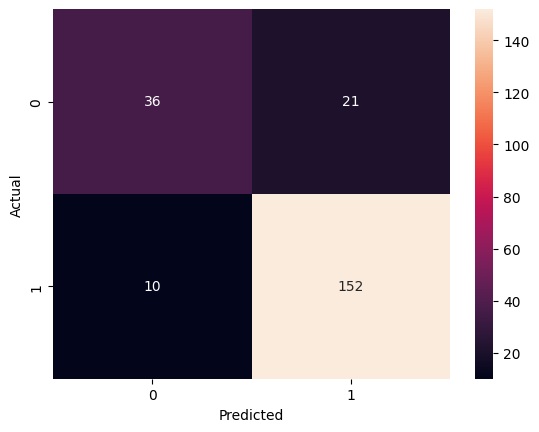

In [31]:
# confusion matrix visualization
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


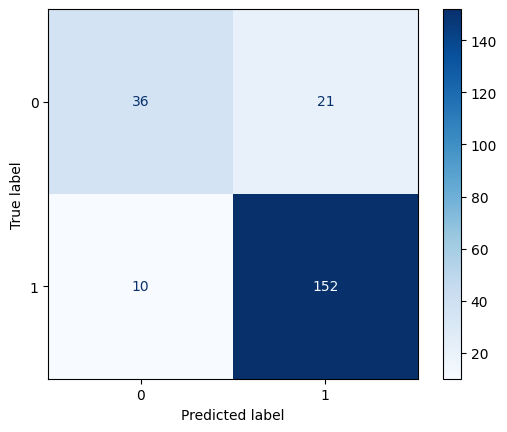

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


    


# SMOTHE

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [34]:
x_resampled.shape, y_resampled.shape

((2640, 10), (2640,))

In [35]:
x_train.shape, y_train.shape

((1752, 10), (1752,))

# Baseline 

In [36]:
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(x_train, y_train)
baseline_y_pred = baseline_model.predict(x_val) 
baseline_cr = classification_report(y_val, baseline_y_pred, output_dict=True)
print(classification_report(y_val, baseline_y_pred))
baseline_ac = accuracy_score(y_val, baseline_y_pred)
print('accuracy score: ', accuracy_score(y_val, baseline_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        57
           1       0.87      0.85      0.86       162

    accuracy                           0.79       219
   macro avg       0.73      0.74      0.74       219
weighted avg       0.80      0.79      0.80       219

accuracy score:  0.7945205479452054
